In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

def smooth_plot(factor, item, plot_decay):
    item_x = np.arange(len(item))
    item_smooth = [np.mean(item[i:i+factor]) if i > factor else np.mean(item[0:i+1])
                  for i in range(len(item))]
    for i in range(len(item)// plot_decay):
        item_x = item_x[::2]
        item_smooth = item_smooth[::2]
    return item_x, item_smooth
    
def plot(episode, rewards, losses, episode_steps):
    clear_output(True)
    rewards_x, rewards_smooth = smooth_plot(10, rewards, 1000)
    losses_x, losses_smooth = smooth_plot(10, losses, 1000)
    episode_steps_x, episode_steps_smooth = smooth_plot(10, episode_steps, 1000)
    
    plt.figure(figsize=(18, 12))
    plt.subplot(311)
    plt.title('Episode %s. reward: %s'%(episode, rewards_smooth[-1]))
    plt.plot(rewards, label="Rewards", color='lightsteelblue', linewidth='1')
    plt.plot(rewards_x, rewards_smooth, label='Smothed_Rewards', color='darkorange', linewidth='3')
    plt.legend(loc='best')
    
    plt.subplot(312)
    plt.title('Losses')
    plt.plot(losses, label="Losses", color='lightsteelblue', linewidth='1')
    plt.plot(losses_x, losses_smooth, 
             label="Smoothed_Losses", color='darkorange', linewidth='3')
    plt.legend(loc='best')
    
    plt.subplot(313)
    plt.title('Episode_Steps %s. Steps: %s'%(episode, episode_steps_smooth[-1]))
    plt.plot(episode_steps, label="Episode_Steps", color='lightsteelblue', linewidth='1')
    plt.plot(episode_steps_x, episode_steps_smooth, 
             label="Episode_Steps_Losses",color='darkorange',linewidth='3')
    plt.legend(loc='best')
    
    plt.show()

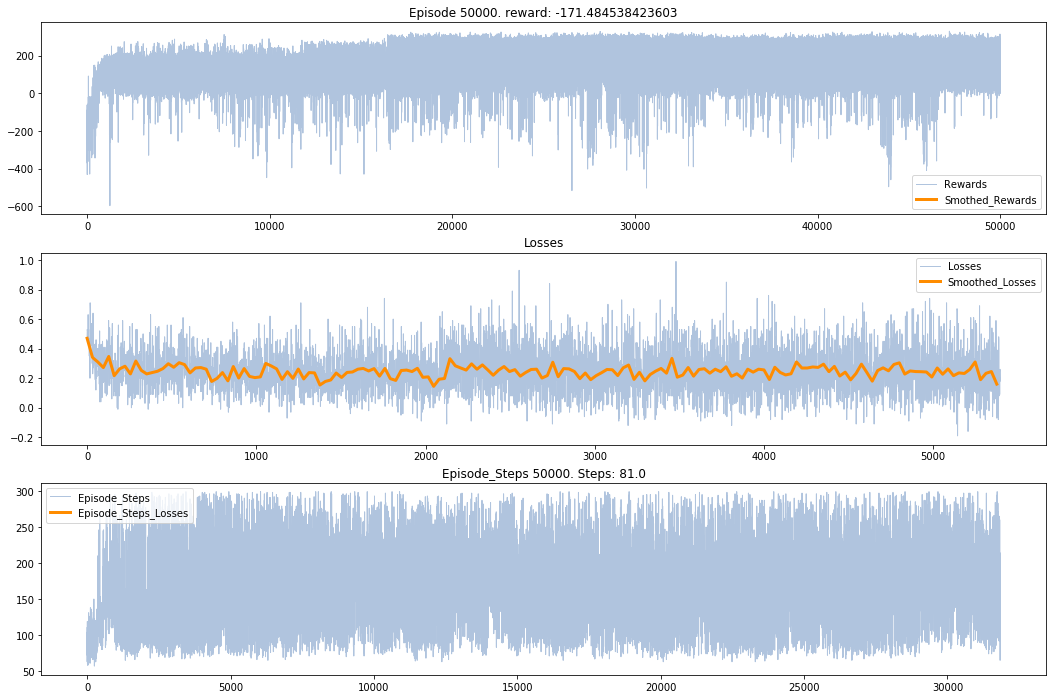

In [2]:
import torch
import torch.nn as nn
from torch.distributions import Categorical
import gym

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, n_latent_var):
        super(ActorCritic, self).__init__()
        self.affine = nn.Linear(state_dim, n_latent_var)
        
        # actor
        self.action_layer = nn.Sequential(
                nn.Linear(state_dim, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, action_dim),
                nn.Softmax(dim=-1)
                )
        
        # critic
        self.value_layer = nn.Sequential(
                nn.Linear(state_dim, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, n_latent_var),
                nn.Tanh(),
                nn.Linear(n_latent_var, 1)
                )
        
    def forward(self):
        raise NotImplementedError
        
    def act(self, state, memory):
        state = torch.from_numpy(state).float().to(device) 
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        action = dist.sample()
        
        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(dist.log_prob(action))
        
        return action.item()
    
    def evaluate(self, state, action):
        action_probs = self.action_layer(state)
        dist = Categorical(action_probs)
        
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        
        state_value = self.value_layer(state)
        
        return action_logprobs, torch.squeeze(state_value), dist_entropy
        
class PPO:
    def __init__(self, state_dim, action_dim, n_latent_var, lr, betas, gamma, K_epochs, eps_clip):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.policy = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        self.policy_old = ActorCritic(state_dim, action_dim, n_latent_var).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()
    
    def update(self, memory):   
        # Monte Carlo estimate of state rewards:
        losses = []
        
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        # Normalizing the rewards:
        rewards = torch.tensor(rewards).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
        
        # convert list to tensor
        old_states = torch.stack(memory.states).to(device).detach()
        old_actions = torch.stack(memory.actions).to(device).detach()
        old_logprobs = torch.stack(memory.logprobs).to(device).detach()
        
        # Optimize policy for K epochs:
        for _ in range(self.K_epochs):
            # Evaluating old actions and values :
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            
            # Finding the ratio (pi_theta / pi_theta__old):
            ratios = torch.exp(logprobs - old_logprobs.detach())
                
            # Finding Surrogate Loss:
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
            
            losses.append(loss.mean().item())
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        
        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())
        return round(np.array(losses).mean(), 2)
        
def main():
    ############## Hyperparameters ##############
    env_name = "LunarLander-v2"
    # creating environment
    env = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = 4
    render = False
    solved_reward = 230         # stop training if avg_reward > solved_reward
    log_interval = 20           # print avg reward in the interval
    max_episodes = 50000        # max training episodes
    max_timesteps = 300         # max timesteps in one episode
    n_latent_var = 64           # number of variables in hidden layer
    update_timestep = 2000      # update policy every n timesteps
    lr = 0.002
    betas = (0.9, 0.999)
    gamma = 0.99                # discount factor
    K_epochs = 4                # update policy for K epochs
    eps_clip = 0.2              # clip parameter for PPO
    random_seed = None
    #############################################
    
    if random_seed:
        torch.manual_seed(random_seed)
        env.seed(random_seed)
    
    memory = Memory()
    ppo = PPO(state_dim, action_dim, n_latent_var, lr, betas, gamma, K_epochs, eps_clip)
    print(lr,betas)
    
    # logging variables
    avg_length = 0
    timestep = 0
    
    all_rewards, all_loss, episode_steps, timestep = [], [], [], 0
    # training loop
    for i_episode in range(1, max_episodes+1):
        state = env.reset()
        running_reward = 0
        for t in range(max_timesteps):
            timestep += 1
            
            # Running policy_old:
            action = ppo.policy_old.act(state, memory)
            state, reward, done, _ = env.step(action)
            
            # Saving reward and is_terminal:
            memory.rewards.append(reward)
            memory.is_terminals.append(done)
            
            # update if its time
            if timestep % update_timestep == 0:
                loss = ppo.update(memory)
                all_loss.append(loss)
                memory.clear_memory()
                timestep = 0
            
            running_reward += reward
            if render:
                env.render()
            if done:
                episode_steps.append(t)
                break
                
        avg_length += t
        
        all_rewards.append(running_reward)
        if i_episode % 20 == 0:
            plot(i_episode, all_rewards, all_loss, episode_steps)
            
            
if __name__ == '__main__':
    main()